Categories in the Fashion-MNIST

|Label | Class |
|-|-|
|0|	T-shirt/top|
|1|	Trouser|
|2|	Pullover|
|3|	Dress|
|4|	Coat|
|5|	Sandal|
|6|	Shirt|
|7|	Sneaker|
|8|	Bag|
|9|	Ankle boot|
|10| Hat |



In [54]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot', 'Hat']

In [84]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from torchvision.transforms import functional
from PIL import ImageStat

from keras.models import load_model
import tensorflow as tf
import cv2


from PIL import Image, ImageOps
from pylab import rcParams
from typing import cast, Any, Union, Dict, List
import time
import random
import copy 
from rembg import remove
from typing import cast, Any, Union, Dict, List
 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import shutil
from collections import OrderedDict

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# See the sample dataset

In [31]:
df = pd.read_csv("Dataset\Deep_Learning_Path.csv",index_col=[0])
train_csv = pd.read_csv(r"DatasetV2\train\Hexacore-Train.csv")
test_csv = pd.read_csv(r"DatasetV2\test\Hexacore-Test.csv")
train_csv_mnist = pd.read_csv(r"Dataset\fashion-mnist_train.csv")
test_csv_mnist = pd.read_csv(r"Dataset\fashion-mnist_test.csv")

In [32]:
print(train_csv.shape)
print(test_csv.shape)

(63400, 785)
(10400, 785)


In [33]:
train_csv

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,1,...,0,1,0,26,99,86,37,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,109,39,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,1,0,19,121,62,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63395,2,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,143,232,139,0,0
63396,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63397,6,0,0,0,0,0,0,0,0,0,...,0,0,0,39,56,18,20,0,0,0
63398,9,0,0,0,0,0,0,0,0,0,...,0,0,6,0,95,119,0,0,0,0


# Dataset
- Build dataset memerlukan inherits dari class `Dataset`
    - `get_item()` return the specified image and it's label
    - `len()` return the number of dataset

In [36]:
class FashionDataset(Dataset):
    def __init__(self, data, transform=None):        
        self.fashion = list(data.values)
        self.transform = transform
        
        label, image = [], []
        
        for i in self.fashion:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28).astype('float32')
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]      
        
        if self.transform is not None:
            # transfrom the numpy array to PIL image before the transform function
            pil_image = Image.fromarray(np.uint8(image)) 
            image = self.transform(pil_image)
            
        return image, label

# Loading Data


In [34]:
## Data Mnist Image folder
train_transform1 = transforms.Compose([
    transforms.RandomChoice([
        transforms.Compose([transforms.RandomVerticalFlip(),transforms.RandomHorizontalFlip()]),
        transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomVerticalFlip()])
    ]),
    transforms.RandomAffine(degrees=30,translate=(0.1,0.1)),
    transforms.Resize((70,70)),
    transforms.ToTensor()
    ])

train_transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((70,70)),
    transforms.ToTensor()
])

train_transform3 = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.ToTensor()
])

train_transform4 = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.ToTensor(),
    transforms.RandomErasing(p=1, scale=(0.02, 0.2))
])

test_transform = transforms.Compose([
    transforms.Resize((70,70)),
    transforms.ToTensor()
])

In [38]:
# Import data
train_set1 = FashionDataset(train_csv,transform=train_transform1)
train_set2 = FashionDataset(train_csv,transform=train_transform2)
train_set3 = FashionDataset(train_csv,transform=train_transform3)
train_set4 = FashionDataset(train_csv,transform=train_transform4)
train_sets = torch.utils.data.ConcatDataset([train_set1,train_set2,train_set3,train_set4])

test_set = FashionDataset(test_csv,transform=test_transform)
train_set, val_set = torch.utils.data.random_split(train_sets, [int(len(train_sets) * 0.9),int(len(train_sets) * 0.1)])

train_dataloader = torch.utils.data.DataLoader(train_set,
                                               batch_size = 100,
                                               shuffle = True)
val_dataloader = torch.utils.data.DataLoader(val_set,
                                             batch_size=100)

loaders = {
    'train' : train_dataloader,
    'val' : val_dataloader
}

In [44]:
# Before Transformation preprcessing data training
print("Before:",len(train_csv))
print("After:",len(train_csv)*4)
#for metrics
dataset_sizes = { 'train': len(train_set), 'val': len(val_set)}
print(dataset_sizes)

Before: 63400
After: 253600
{'train': 228240, 'val': 25360}


In [46]:
print("Before:",len(test_csv))
#for metrics
print(len(test_set))

Before: 10400
10400


### See Images on Dataset Tranfromation

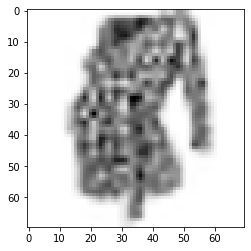

In [63]:
i = np.random.randint(50)
x,y = next(iter(train_dataloader))
plt.imshow(x[i].permute(1,2,0),cmap='Greys')

In [74]:
np.sort(y.unique())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

# Preprcessing Ultilization

In [81]:
# Show Function for image tensor
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

def is_grayscale(path):
    im = Image.open(path).convert("RGB")
    stat = ImageStat.Stat(im)
    if sum(stat.sum)/3 == stat.sum[0]: #check the avg with any element value
        return True #if grayscale
    else:
        return False #else its colour

def resize_with_pad(im, target_width, target_height):
    '''
    Resize PIL image keeping ratio and using white background.
    '''
    target_ratio = target_height / target_width
    im_ratio = im.height / im.width
    if target_ratio > im_ratio:
        # It must be fixed by width
        resize_width = target_width
        resize_height = round(resize_width * im_ratio)
    else:
        # Fixed by height
        resize_height = target_height
        resize_width = round(resize_height / im_ratio)
    image_resize = im.resize((resize_width, resize_height), Image.ANTIALIAS)
    background = Image.new('RGBA', (target_width, target_height), (255, 255, 255, 255))
    offset = (round((target_width - resize_width) / 2), round((target_height - resize_height) / 2))
    background.paste(image_resize, offset)
    return background.convert('RGB')

def CropObject(IMG: Image):
    im = IMG
    p, l = im.size
    base_ori = Image.new('RGB', (p, l), (255, 255, 255))
    output = remove(im)
    base_ori.paste(output, (0,0), output)
    base_ori = base_ori.convert("RGB")
    p, l = base_ori.size
    pix = base_ori.load()
    termination = [(0,0,0), (255,255,255)]

    hasil = -1
    for y in range(0, l):
        for x in range(0, p):
            if (pix[x, y] not in termination):
                hasil = y
                break
        if (hasil!=-1):
            break
    left = 0 ;upper = hasil ;right = p ;lower = l
    ori_crop1 = base_ori.crop((left, upper, right, lower))

    hasil = -1
    pix = ori_crop1.load()
    p, l = ori_crop1.size
    for y in range(l-1, 0, -1):
        for x in range(0, p):
            if (pix[x, y] not in termination):
                hasil = y
                break
        if (hasil!=-1):
            break
    left = 0; upper = 0; right = p; lower = l-(l-hasil)
    ori_crop2 = ori_crop1.crop((left, upper, right, lower))

    hasil = -1
    pix = ori_crop2.load()
    p, l = ori_crop2.size
    for x in range(0, p):
        for y in range(0, l):
            if (pix[x, y] not in termination):
                hasil = x
                break
        if (hasil!=-1):
            break
    left = hasil; upper = 0; right = p; lower = l
    ori_crop3 = ori_crop2.crop((left, upper, right, lower))

    hasil = -1
    pix = ori_crop3.load()
    p, l = ori_crop3.size
    for x in range(p-1, 0, -1):
        for y in range(0, l):
            if (pix[x, y] not in termination):
                hasil = x
                break
        if (hasil!=-1):
            break
    left = 0; upper = 0; right = p - (p-hasil); lower = l
    ori_crop4 = ori_crop3.crop((left, upper, right, lower))

    return ori_crop4

class fashion_tools_segmentation(object):
    def __init__(self,imageid,model,version=1.1):
        self.imageid = imageid
        self.model   = model
        self.version = version

    def get_dress(self,stack=False):
        """limited to top wear and full body dresses (wild and studio working)"""
        """takes input rgb----> return PNG"""
        name =  self.imageid
        file = cv2.imread(name)
        file = tf.image.resize_with_pad(file,target_height=512,target_width=512)
        rgb  = file.numpy()
        file = np.expand_dims(file,axis=0)/ 255.
        seq = self.model.predict(file)
        seq = seq[3][0,:,:,0]
        seq = np.expand_dims(seq,axis=-1)
        c1x = rgb*seq
        c2x = rgb*(1-seq)
        cfx = c1x+c2x
        dummy = np.ones((rgb.shape[0],rgb.shape[1],1))
        rgbx = np.concatenate((rgb,dummy*255),axis=-1)
        rgbs = np.concatenate((cfx,seq*255.),axis=-1)
        if stack:
            stacked = np.hstack((rgbx,rgbs))
            return stacked
        else:
            return rgbs

    def get_patch(self):
        return None

# Visualisasi data kelas


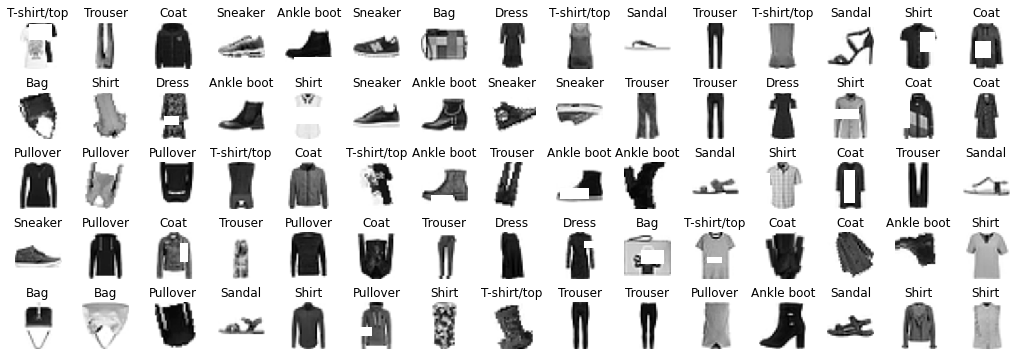

In [80]:
n_rows = 5
n_cols = 15
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
x,y = next(iter(train_dataloader))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(x[index].permute(1,2,0), cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()